In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from natsort import natsorted, order_by_index, index_natsorted
import os
%matplotlib inline

In [2]:
def create_barplot(df, x, y, folder="../thesis/pictures/", 
                   filename=None, fformat="svg", rotation=35,
                  labely="SCORE", labelx="", show=True, **kwargs):
    
    options = dict(palette="tab10", height=8.27, aspect=11.7/8.27, kind="bar", hue=None)
    options.update(kwargs)
        
    g = sns.catplot(
        data=df, x=x, y=y, ci="sd",**options
    )
    g.despine(left=True)
    g.set_axis_labels(labelx, labely)
    g.set_xticklabels(rotation=rotation)
    if filename:
        plt.savefig(folder+filename+"."+fformat, format=fformat)
    if show:
        plt.show()
    return g

def load_and_add_col(name_and_path):
    name, path = name_and_path
    df = pd.read_csv(path, sep="\t")
    df["name"] = name
    return df

In [3]:
remap = {0: "0 - letter", 1: "1 - email", 2: "2 - form", 3: "3 - handwritten", 4: "4 - advertisement", 
         5: "5 - scientific report", 6: "6 - scientific publication", 7: "7 - specification", 
         8: "8 - file folder", 9: "9 - news article", 10: "10 - budget", 11: "11 - invoice", 
         12: "12 - presentation",13: "13 - questionnaire", 14:"14 resume", 15: "15 - memo"}

score_cols = ['f1_macro',              'in_f1',              'in_prec',              'in_rec',
              'out_f1',              'out_prec',
              'out_rec', "roc_auc"
             ]
scores_cols2 = ["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]
groupcols = ["name", "cclass"]

inliers = [0, 1, 2, 11]

## One Out Different Architectures

f1_macro        f1    in_rec   out_rec   roc_auc  \
name       balanced                                                     
NN         0.0       0.623373  0.906251  0.971735  0.253627  0.747703   
           1.0       0.539673  0.715540  0.966750  0.252833  0.753233   
OCNN-NN    0.0       0.644891  0.869840  0.863528  0.460970  0.747791   
           1.0       0.639362  0.726936  0.856266  0.473229  0.742385   
OCNN-OCSVM 0.0       0.448852  0.897704  1.000000  0.000000  0.688331   
           1.0       0.333333  0.666667  1.000000  0.000000  0.694637   
OCNN-SVM   0.0       0.672649  0.884658  0.885069  0.492091  0.780138   
           1.0       0.657198  0.745205  0.888238  0.479223  0.783993   
OCSVM      0.0       0.544022  0.715743  0.599534  0.646953  0.623243   
           1.0       0.623373  0.628066  0.609515  0.646953  0.628234   
SVM        0.0       0.702298  0.898953  0.903648  0.534641  0.719144   
           1.0       0.693451  0.771641  0.900676  0.534641  0.717659   

                       pr_auc  
name       balanced            
NN         0.0       0.905624  
           1.0       0.724903  
OCNN-NN    0.0       0.918663  
           1.0       0.742773  
OCNN-OCSVM 0.0       0.896845  
           1.0       0.689233  
OCNN-SVM   0.0       0.927262  
           1.0       0.780387  
OCSVM      0.0       0.860426  
           1.0       0.600628  
SVM        0.0       0.888854  
           1.0       0.668860

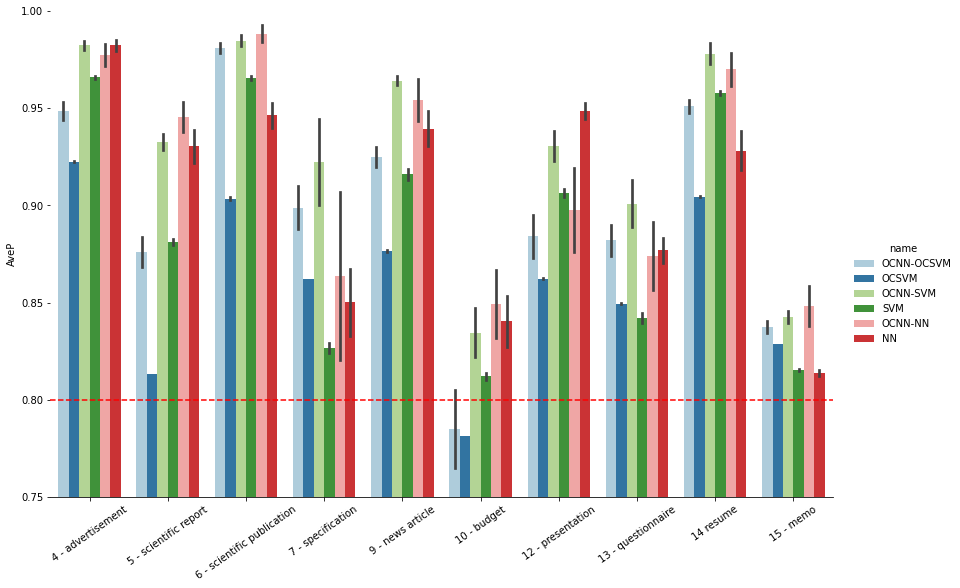

In [6]:
balanced=0
score = "pr_auc"

fold = "../reports/final/oc_b/"
filelist = [("OCNN-OCSVM", f"{fold}one_out_oc_nn_ocsvm_bub.tsv"),
            ("OCSVM", f"{fold}one_out_ocsvm_bub.tsv"),
           ("OCNN-SVM", f"{fold}one_out_oc_nn_svm_b.tsv"),
            ("OCNN-SVM", f"../reports/one_class/one_out_oc_0002_nn_svm_ub.tsv"),
            ("SVM", f"{fold}one_out_svm.tsv"),
            ("OCNN-NN", f"{fold}one_out_oc_nn_nn_bub_weakly.tsv")
           ]

df = pd.concat([load_and_add_col(x) for x in filelist])
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df.weakly = df.weakly.fillna(0)
#df = df.where(~df.weakly.isin([5.0,15.0])).dropna(how="all")

df_temp = pd.read_csv("../reports/final/supverised/one_out_standard_sup.tsv", sep="\t")
df_temp["name"] = "NN"
df_temp["cclass"] = df_temp.in_test_not_train_outlier.map(lambda x: eval(x)[0])
df_temp["balanced"] = df_temp.balance

df = pd.concat([df, df_temp])
df.balanced = df.balanced.fillna(1)
df_bub = df.copy(deep=True)
df = df.where(df.balanced==balanced).dropna(how="all")
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="name", kind="bar", labely=score, show=False, palette="Paired")
g.set(ylim=(0.75,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/ocnn-models-comparison.svg", format="svg")

df_group = df_bub.groupby(["name", "balanced"]).mean()[scores_cols2]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
#print(latex_code)
df_group

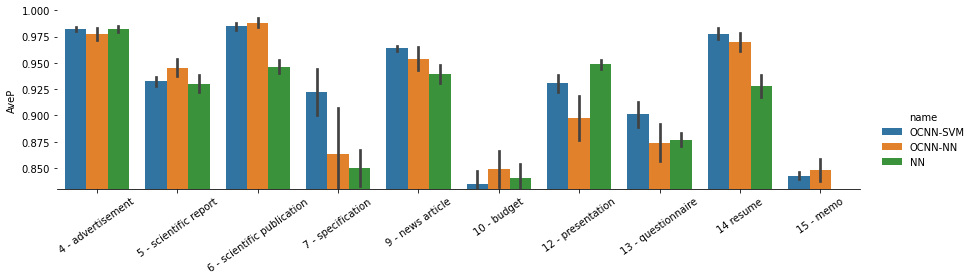

In [34]:
hue_order = ["OCNN-SVM", "OCNN-NN", "NN"]
g = create_barplot(df, x="cclass", y=score, hue="name", kind="bar", labely=score, show=False, hue_order=hue_order,
                  height=4, aspect=3/1)
g.set(ylim=(0.83,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/ocnn-models-comparison-zoom.svg", format="svg")

## All Different Architectures

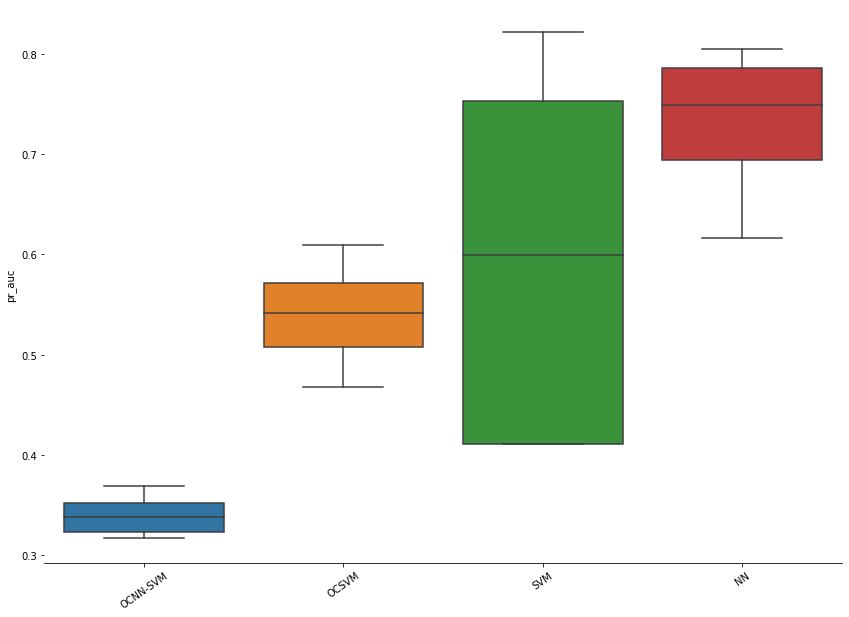

\begin{tabular}{lrrr}
\toprule
{} &  f1\_macro &    in\_rec &   out\_rec \\ \hline
name     &           &           &           \\ \hline
\midrule
NN       &  0.737522 &  0.959031 &  0.499459 \\ \hline
OCNN-SVM &  0.339913 &  0.943297 &  0.116901 \\ \hline
OCSVM    &  0.538513 &  0.602277 &  0.535430 \\ \hline
SVM      &  0.580794 &  0.340933 &  0.919732 \\ \hline
\bottomrule
\end{tabular}



,f1_macro,in_rec,out_rec
name,,,
NN,0.737522,0.959031,0.499459
OCNN-SVM,0.339913,0.943297,0.116901
OCSVM,0.538513,0.602277,0.535430
SVM,0.580794,0.340933,0.919732


In [7]:
fold = "../reports/final/oc_b/"
filelist = [("OCNN-SVM", f"{fold}all_nn_svm_b_20.tsv"),
           ("OCSVM", f"{fold}all_pure_oc_svm_bub.tsv"),
           ("SVM", f"{fold}all_pure_svm_bub.tsv"),
            ("NN", "../reports/final/supverised/all_standard_sup_oe.tsv")
           ]

df = pd.concat([load_and_add_col(x) for x in filelist])
create_barplot(df, x="name", y="f1_macro", kind="box", labely=score, show=True)
df = df.groupby(["name"]).mean()[score_cols]

latex_code = df[["f1_macro", "in_rec", "out_rec"]].to_latex()
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
print(latex_code)
df[["f1_macro", "in_rec", "out_rec"]]

## 20 News

\begin{tabular}{llrrrrrr}
\toprule
                 &     &  f1\_macro &    f1 &  in\_rec &  out\_rec &  roc\_auc &  pr\_auc \\ \hline
name & balanced &           &       &         &          &          &         \\ \hline
\midrule
OCNN-NN & 0.0 &     0.645 & 0.870 &   0.864 &    0.461 &    0.748 &   0.919 \\ \hline
                 & 1.0 &     0.639 & 0.727 &   0.856 &    0.473 &    0.742 &   0.743 \\ \hline
OCNN-NN 20 News & 0.0 &     0.531 & 0.826 &   0.825 &    0.255 &    0.560 &   0.839 \\ \hline
                 & 1.0 &     0.451 & 0.629 &   0.828 &    0.193 &    0.508 &   0.514 \\ \hline
OCNN-NN Both & 0.0 &     0.619 & 0.810 &   0.743 &    0.609 &    0.732 &   0.909 \\ \hline
OCNN-OCSVM & 0.0 &     0.449 & 0.898 &   1.000 &    0.000 &    0.688 &   0.897 \\ \hline
                 & 1.0 &     0.333 & 0.667 &   1.000 &    0.000 &    0.695 &   0.689 \\ \hline
OCNN-OCSVM 20 News & 0.0 &     0.449 & 0.898 &   1.000 &    0.000 &    0.649 &   0.882 \\ \hline
                 & 1.0 &  

f1_macro        f1    in_rec   out_rec   roc_auc  \
name               balanced                                                     
OCNN-NN            0.0       0.644891  0.869840  0.863528  0.460970  0.747791   
                   1.0       0.639362  0.726936  0.856266  0.473229  0.742385   
OCNN-NN 20 News    0.0       0.530520  0.826185  0.824574  0.254800  0.560257   
                   1.0       0.450536  0.628962  0.827760  0.192599  0.508004   
OCNN-NN Both       0.0       0.618618  0.810476  0.742579  0.609325  0.732488   
OCNN-OCSVM         0.0       0.448852  0.897704  1.000000  0.000000  0.688331   
                   1.0       0.333333  0.666667  1.000000  0.000000  0.694637   
OCNN-OCSVM 20 News 0.0       0.448852  0.897704  1.000000  0.000000  0.648535   
                   1.0       0.333333  0.666667  1.000000  0.000000  0.664840   
OCNN-SVM           0.0       0.672649  0.884658  0.885069  0.492091  0.780138   
                   1.0       0.657198  0.745205  0.888238  0.479223  0.783993   
OCNN-SVM 20 News   0.0       0.530563  0.879679  0.941537  0.133437  0.593665   
                   1.0       0.427752  0.666610  0.942291  0.113732  0.574784   

                               pr_auc  
name               balanced            
OCNN-NN            0.0       0.918663  
                   1.0       0.742773  
OCNN-NN 20 News    0.0       0.838707  
                   1.0       0.513992  
OCNN-NN Both       0.0       0.909247  
OCNN-OCSVM         0.0       0.896845  
                   1.0       0.689233  
OCNN-OCSVM 20 News 0.0       0.881655  
                   1.0       0.662242  
OCNN-SVM           0.0       0.927262  
                   1.0       0.780387  
OCNN-SVM 20 News   0.0       0.851988  
                   1.0       0.566498

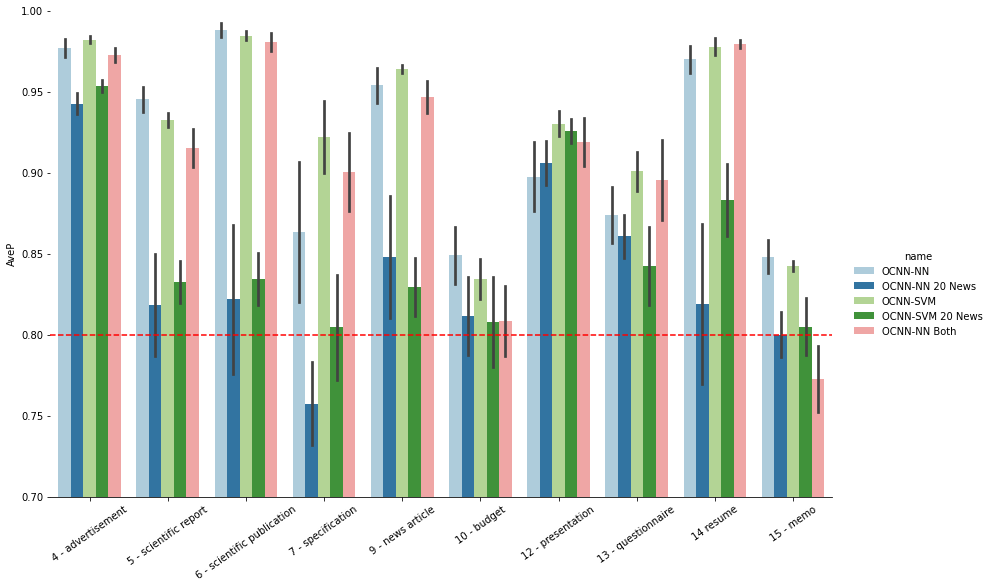

In [35]:
balanced=0
score = "pr_auc"

fold = "../reports/final/oc_b/"
filelist = [("OCNN-NN", f"{fold}one_out_oc_nn_nn_bub_weakly.tsv"),
            ("OCNN-NN 20 News", f"{fold}one_out_oc_nn_nn_b_20.tsv"),
           ("OCNN-OCSVM", f"{fold}one_out_oc_nn_ocsvm_bub.tsv"),
           ("OCNN-OCSVM 20 News", f"{fold}one_out_oc_nn_ocsvm_b_20.tsv"),
           ("OCNN-SVM", f"{fold}one_out_oc_nn_svm_b.tsv"),
            ("OCNN-SVM", f"../reports/one_class/one_out_oc_0002_nn_svm_ub.tsv"),
           ("OCNN-SVM 20 News", f"{fold}one_out_oc_nn_svm_b_20.tsv"),
            ("OCNN-NN Both", "../reports/one_class/one_out_oc_0001_nn_both_data_ub.tsv")
           ]

names = {"nn":"OCNN-NN 20 News", "ocsvm":"OCNN-OCSVM 20 News", "svm":"OCNN-SVM 20 News"}

df = pd.concat([load_and_add_col(x) for x in filelist])
#df = df.where(~df.weakly.isin([5.0,15.0])).dropna(how="all")

df_temp = pd.read_csv(f"{fold}one_out_oc_nn_20news_ub.tsv", sep="\t")
df_temp["name"] = df_temp.pred_mode.map(lambda x: names[x])
df_temp["data"] = "20news"
df = df.append(df_temp)


df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df.balanced = df.balanced.fillna(1)
df_bub = df.copy(deep=True)
df = df.where(df.balanced==balanced).dropna(how="all")
df = df.replace({"cclass":remap})

hue_order = ["OCNN-NN", "OCNN-NN 20 News", "OCNN-SVM", "OCNN-SVM 20 News", "OCNN-NN Both"]
g = create_barplot(df, x="cclass", y=score,  labely=score, show=False, hue="name", 
                   kind="bar", hue_order=hue_order, palette="Paired")
g.set(ylim=(0.7,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/ocnn-models-20news.svg", format="svg")

#df_bub = df_bub.where(df_bub.data=="20news").dropna(how="all")
df_group = df_bub.groupby(["name", "balanced"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
print(latex_code)
df_group

## Multimodal

\begin{tabular}{llrrrrrr}
\toprule
         &     &  f1\_macro &    f1 &  in\_rec &  out\_rec &  roc\_auc &  pr\_auc \\ \hline
name & balanced &           &       &         &          &          &         \\ \hline
\midrule
Image & 0.0 &     0.590 & 0.888 &   0.950 &    0.234 &    0.648 &   0.865 \\ \hline
Text & 0.0 &     0.645 & 0.870 &   0.864 &    0.461 &    0.748 &   0.919 \\ \hline
Text+Img & 0.0 &     0.725 & 0.917 &   0.951 &    0.495 &    0.827 &   0.944 \\ \hline
\bottomrule
\end{tabular}



,,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
name,balanced,,,,,,
Image,0.0,0.590437,0.887893,0.950258,0.234241,0.648239,0.865411
Text,0.0,0.644891,0.869840,0.863528,0.460970,0.747791,0.918663
Text+Img,0.0,0.724725,0.916732,0.950626,0.495426,0.827029,0.943687


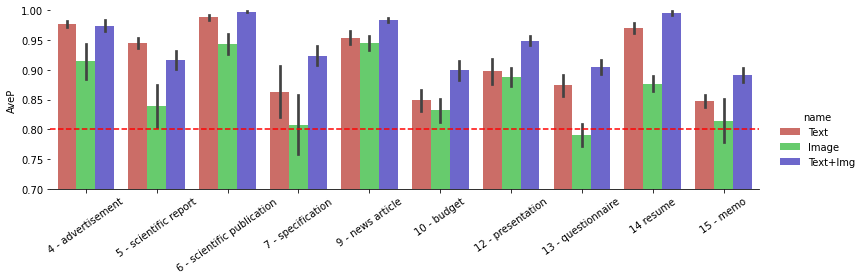

In [37]:
fold = "../reports/"
balanced = 0
score = "pr_auc"

filelist = [("Text", f"{fold}final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"),
           ("Image", f"../reports/one_class/one_out_oc_0001_nn_image.tsv"),
           ("Text+Img", f"../reports/one_class/one_out_oc_0002_nn_combined.tsv")]

df = pd.concat([load_and_add_col(x) for x in filelist])
df = df.where(df.balanced==balanced).dropna(how="all")
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="name", kind="bar", labely=score, show=False, 
                   height=4, aspect=8/3, palette="hls")
g.set(ylim=(0.7,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/multimodal_PRC.svg", format="svg")

df_group = df.groupby(["name", "balanced"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
print(latex_code)
df_group

,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
f1_macro,1.000000,0.073557,-0.182787,0.900842,0.850094,0.390703
f1,0.073557,1.000000,0.871141,0.183075,0.374303,0.873577
in_rec,-0.182787,0.871141,1.000000,-0.140013,0.094046,0.583969
out_rec,0.900842,0.183075,-0.140013,1.000000,0.927466,0.473941
roc_auc,0.850094,0.374303,0.094046,0.927466,1.000000,0.649813
pr_auc,0.390703,0.873577,0.583969,0.473941,0.649813,1.000000


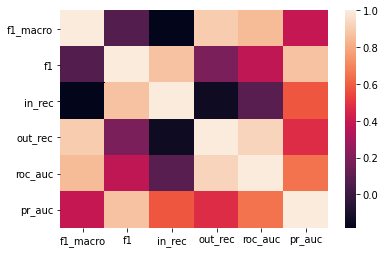

In [11]:
balanced = 0
df = pd.concat([load_and_add_col(x) for x in filelist])
df = df.where(df.balanced==balanced).dropna(how="all")
sns.heatmap(df[scores_cols2].corr())
df[scores_cols2].corr()

In [12]:
news_20_files = [(r ,files[x]) for x, r in [(8, "NN-SVM"), (11, "NN-SVM UMAP")]]

df = pd.concat([load_and_add_col(x) for x in news_20_files])
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})
df = df.groupby(groupcols).mean()[score_cols]
table = pd.pivot_table(df.reset_index(), index='cclass', columns='name', values='f1_macro')
table = table.reindex(index=order_by_index(table.index, index_natsorted(table.index)))
print(arch_files)
table.plot(kind='barh', figsize=(11,8), fontsize=12, width=0.8)
print(table.to_latex())

NameError: name 'files' is not defined

## Weakly

,,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
weakly,balanced,,,,,,
0.0,0.0,0.638865,0.869187,0.865647,0.444119,0.738865,0.914305
5.0,0.0,0.642044,0.868292,0.861147,0.459390,0.743364,0.916078
15.0,0.0,0.642184,0.867550,0.859877,0.459495,0.742040,0.915559


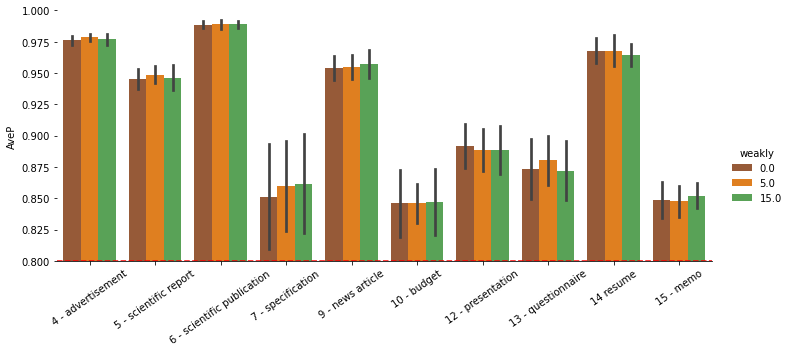

In [38]:
balanced=0
score="pr_auc"

#path = "../reports/final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"
path = "../reports/one_class/one_out_oc_0001_weakly.tsv"
df = pd.read_csv(path, sep="\t")
df.weakly = df.weakly.fillna(0)
df_bub = df.copy(deep=True)
df = df.where(df.balanced==balanced).dropna(how="all")
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="weakly", kind="bar", labely="AU-PRC", 
                   show=False, height=5, aspect=6/3, palette="Set1_r")
g.set(ylim=(0.8,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/weakly-sup.svg", format="svg")

df_group = df_bub.groupby(["weakly", "balanced"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
#print(latex_code)
df_group

## Balanced data

In [ ]:
folder = "../reports/final/oc_b/"
files = sorted([folder+x for x in os.listdir(folder)])
[(i, x) for i, x in enumerate(files)]

In [ ]:
import seaborn as sns
path = "../reports/final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"
df = pd.read_csv(path, sep="\t")
df = df.fillna(0)
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})
df = df.where(df.balanced==False)
sns.heatmap(df[scores_cols2].corr())
df = df.rename({"f1_macro":"F1 macro"})
df[scores_cols2].corr()

In [ ]:
import seaborn as sns
score_cols = ['accuracy','f1', 'f1_macro', 'in_f1',
       'in_prec', 'in_rec', 'out_f1', 'out_prec',
       'out_rec', 'pr_auc', 'roc_auc']
path = "../reports/final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"
df = pd.read_csv(path, sep="\t")
df = df.fillna(0)
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

#df.groupby(["balanced"]).mean()[score_cols]
unstacked = df[score_cols].unstack().to_frame()
sns.barplot(
    y=unstacked.index.get_level_values(0),
    x=unstacked[0]);


In [ ]:
import seaborn as sns
path = "../reports/final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"
df = pd.read_csv(path, sep="\t")
df = df.fillna(0)
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[score_cols+["balanced"]].melt(id_vars=['balanced'])
sns.catplot(kind="bar", data=df, x="variable", y="value", hue="balanced", height=5, aspect=5/2)

In [ ]:
import seaborn as sns
path = "../reports/final/oc_b/all_oc_all_bub.tsv"
df = pd.read_csv(path, sep="\t")
df = df.fillna(0)
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[score_cols+["pred_mode"]].melt(id_vars=['pred_mode'])
sns.catplot(kind="bar", data=df, x="variable", y="value", hue="pred_mode", height=5, aspect=5/2)

In [ ]:
sns.lmplot(x='f1_macro',y='in_rec',data=df,fit_reg=True) 

In [ ]:
path = "../reports/one_class/one_out_oc_0001_nn_ocsvm_b_20.tsv"
df = pd.read_csv(path, sep="\t")
df = df.fillna(0)
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})
df = df[score_cols+["pr_auc", "balanced"]]
df.groupby(["balanced"]).mean()

## RO-Curve Text

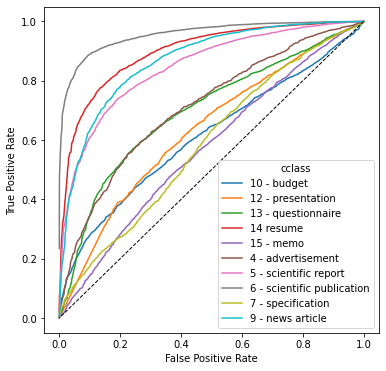

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

path = "../reports/one_class/one_out_oc_0002_nn_roc_prc.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[["cclass", "tpr", "fpr"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

df_roc = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df_roc.fpr = df_roc.fpr.astype(float)
df_roc.tpr = df_roc.tpr.astype(float)
g = sns.lineplot(data=df_roc, x="fpr", y="tpr", hue="cclass", ci=None, palette="tab10")
plt.plot([1, 0], [1,0], color="black", linestyle='dashed', linewidth=1)
g.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.savefig("../thesis/pictures/roc-text.svg", format="svg")

## PR-Curve Text

[0.79977976 0.79975971 0.79973966 ... 1.         1.         1.        ]


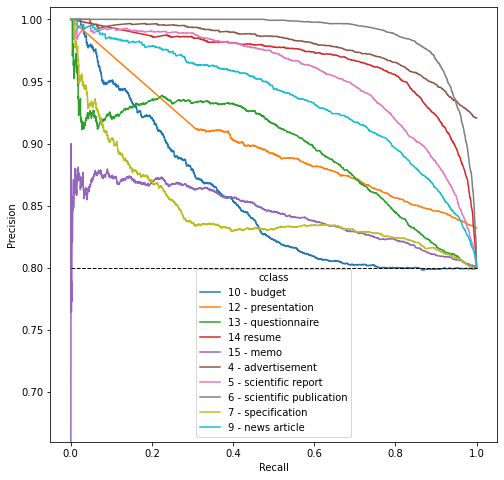

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

path = "../reports/one_class/one_out_oc_0002_nn_roc_prc.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[["cclass", "precision", "recall"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

print(df.iloc[0].precision)
df_roc = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df_roc.precision = df_roc.precision.astype(float)
df_roc.recall = df_roc.recall.astype(float)
g = sns.lineplot(data=df_roc, x="recall", y="precision", hue="cclass", ci=None, palette="tab10")
plt.plot([0, 1], [0.8, 0.8], color="black", linestyle='dashed', linewidth=1)
g.set(xlabel='Recall', ylabel='Precision')
g.set(ylim=(0.66,1.01))
#plt.legend().remove()
plt.savefig("../thesis/pictures/prc-text.svg", format="svg")

## RO-Curve Combined

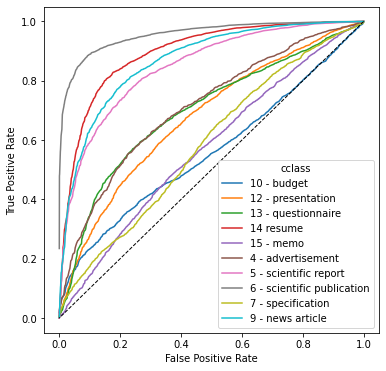

In [40]:
plt.figure(figsize=(6,6))

path = "../reports/one_class/one_out_oc_0002_nn_roc_prc.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[["cclass", "tpr", "fpr"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

df_roc = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df_roc.fpr = df_roc.fpr.astype(float)
df_roc.tpr = df_roc.tpr.astype(float)
g = sns.lineplot(data=df_roc, x="fpr", y="tpr", hue="cclass", ci=None, palette="tab10")
plt.plot([1, 0], [1,0], color="black", linestyle='dashed', linewidth=1)
g.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.savefig("../thesis/pictures/roc-combined.svg", format="svg")

## PR-Curve Combined

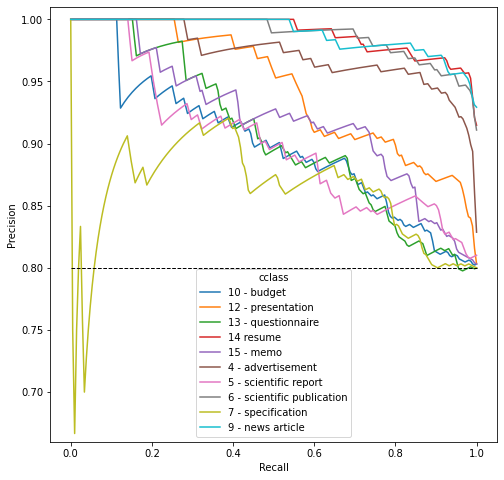

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

path = "../reports/one_class/one_out_oc_0002_nn_combined_prc.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

df = df[["cclass", "precision", "recall"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

df_roc = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df_roc.precision = df_roc.precision.astype(float)
df_roc.recall = df_roc.recall.astype(float)
g = sns.lineplot(data=df_roc, x="recall", y="precision", hue="cclass", ci=None, palette="tab10")
plt.plot([0, 1], [0.8, 0.8], color="black", linestyle='dashed', linewidth=1)
g.set(xlabel='Recall', ylabel='Precision')
g.set(ylim=(0.66,1.01))
#plt.legend().remove()
plt.savefig("../thesis/pictures/prc-combined.svg", format="svg")

## F1 Macro Curve

/home/philipp/projects/dad4td/dad4tdenv/lib/python3.6/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

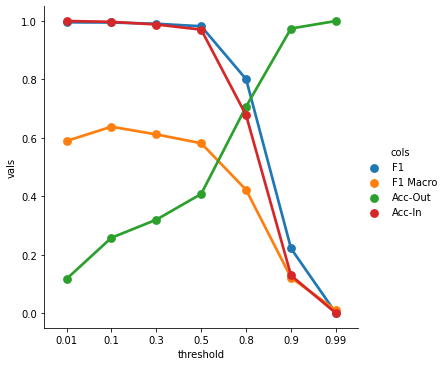

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

path = "../reports/one_class/one_out_oc_0003_nn_roc_prc_combined.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

rename_cols = {"f1": "F1", "f1_macro": "F1 Macro", "out_rec": "Acc-Out", "in_rec":"Acc-In"}
df = df.rename(columns=rename_cols)
df = df.groupby(["threshold"]).mean()[list(rename_cols.values())].reset_index()
df = df.melt('threshold', var_name='cols',  value_name='vals')
g = sns.factorplot(x="threshold", y="vals", hue='cols', data=df)


/home/philipp/projects/dad4td/dad4tdenv/lib/python3.6/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

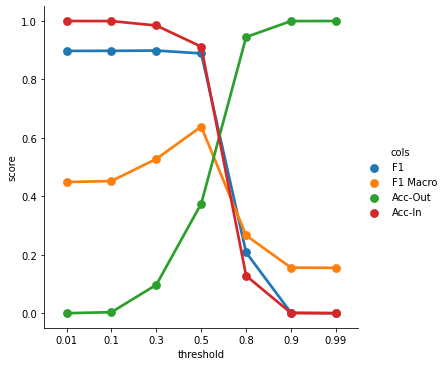

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

path = "../reports/one_class/one_out_oc_0001_nn_text_trhesholds.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})

rename_cols = {"f1": "F1", "f1_macro": "F1 Macro", "out_rec": "Acc-Out", "in_rec":"Acc-In"}
df = df.rename(columns=rename_cols)
df = df.groupby(["threshold"]).mean()[list(rename_cols.values())].reset_index()
df = df.melt('threshold', var_name='cols',  value_name='score')
g = sns.factorplot(x="threshold", y="score", hue='cols', data=df)


,threshold,cols,score
0,0.00,F1,0.958661
1,0.01,F1,0.958661
2,0.02,F1,0.958661
3,0.03,F1,0.958661
4,0.04,F1,0.958661
...,...,...,...
399,0.96,Acc-Out,1.000000
400,0.97,Acc-Out,1.000000
401,0.98,Acc-Out,1.000000
402,0.99,Acc-Out,1.000000


<Figure size 720x720 with 0 Axes>

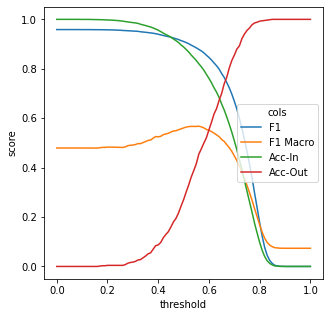

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

path = "../reports/one_class/one_out_oc_0002_nn_text_trhesholds.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})
df = df[["cclass","F1", "F1 Macro", "Acc-In", "Acc-Out"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

df = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df = df.apply(pd.to_numeric, errors='coerce')
df["threshold"] = df.index % 101/ 100
test = df.index
del df["cclass"]
df = df.melt('threshold', var_name='cols',  value_name='score')
plt.figure(figsize=(5,5))
g = sns.lineplot(x="threshold", y="score", hue='cols', data=df, ci=None)
plt.savefig("../thesis/pictures/scores_text.svg", format="svg")
df

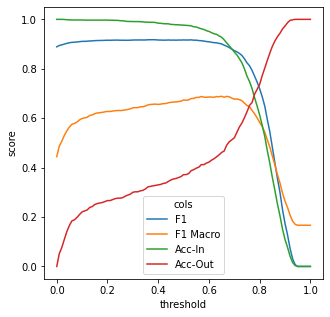

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


path = "../reports/one_class/one_out_oc_0002_nn_combined_prc.pkl"
df = pd.read_pickle(path)
df.cclass = df.cclass.map(lambda l: [x for x in l if x not in inliers][0])
df = df.replace({"cclass":remap})
df = df[["cclass","F1", "F1 Macro", "Acc-In", "Acc-Out"]]
df = df.groupby('cclass', group_keys=False).apply(lambda df: df.sample(1))

df = df.set_index(['cclass']).apply(pd.Series.explode).reset_index()
df = df.apply(pd.to_numeric, errors='coerce')
df["threshold"] = df.index % 101/ 100
test = df.index
del df["cclass"]
df = df.melt('threshold', var_name='cols',  value_name='score')
plt.figure(figsize=(5,5))
g = sns.lineplot(x="threshold", y="score", hue='cols', data=df, ci=None)
plt.savefig("../thesis/pictures/scores_combined.svg", format="svg")

## UMAP

<Figure size 720x720 with 0 Axes>

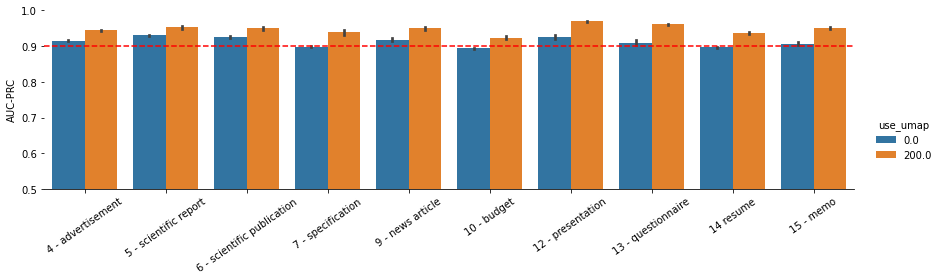

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

score = "pr_auc"

path = "../reports/supervised/sup_one_to_many_UMAP0001.tsv"
df = pd.read_csv(path, sep="\t")
df = df.where(df.use_umap != 5).dropna(how="all")
df["cclass"] = df.outliers.map(lambda x: eval(x)[0])
df = df.replace({"cclass":remap})

#hue_order = ["OCNN-SVM", "OCNN-NN", "NN"]
g = create_barplot(df, x="cclass", y=score, hue="use_umap", kind="bar", labely=score, show=False,
                  height=4, aspect=3/1)
g.set(ylim=(0.5,1.0))
g.map(plt.axhline, y=0.9, ls='--', c='red')
g.set_axis_labels("", "AUC-PRC")
#plt.savefig("../thesis/pictures/ocnn-models-comparison-zoom.svg", format="svg")

,,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
weakly,use_umap,,,,,,


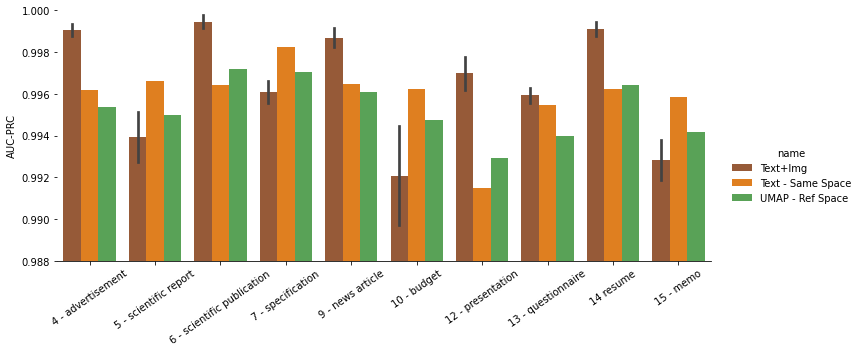

In [47]:
balanced=0
score="pr_auc"

filelist = [("Text+Img", f"../reports/one_class/one_out_oc_0001_nn__bub_imgtxt.tsv"),
    ("Text - Same Space", f"../reports/one_class/one_out_oc_0001_nn_combined_umap_samespace.tsv"),
           ("UMAP - Ref Space", f"../reports/one_class/one_out_oc_0001_nn_combined_umap_refspace.tsv"),
           ]

df = pd.concat([load_and_add_col(x) for x in filelist])

df.use_umap = df.use_umap.fillna(0)
df_bub = df.copy(deep=True)
df = df.where(df.balanced==0).dropna(how="all")
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="name", kind="bar", labely="AU-PRC", 
                   show=False, height=5, aspect=6/3, palette="Set1_r")
g.set(ylim=(0.988,1.0))
g.map(plt.axhline, y=0.9, ls='--', c='red')
g.set_axis_labels("", "AUC-PRC")
#plt.savefig("../thesis/pictures/weakly-sup.svg", format="svg")

df_group = df_bub.groupby(["weakly", "use_umap"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
#print(latex_code)
df_group

0      [4]
1      [5]
2      [6]
3      [7]
4      [9]
      ... 
85    [10]
86    [12]
87    [13]
88    [14]
89    [15]
Name: outliers, Length: 90, dtype: object


,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
name,,,,,,
NN - Text,0.623373,0.906251,0.971735,0.253627,0.747703,0.905624
NN - Text UMAP,0.488269,0.941665,0.996692,0.018460,0.705386,0.947569
OCNN Image,0.531015,0.975247,0.959200,0.221156,0.683899,0.994184
OCNN Image UMAP,0.497485,0.994970,1.000000,0.000000,0.553786,0.992322
OCNN Text,0.644891,0.869840,0.863528,0.460970,0.747791,0.918663
OCNN Text UMAP,0.475732,0.887642,0.971986,0.082416,0.643777,0.890096
OCNN Text+Img,0.571109,0.977239,0.960796,0.447879,0.786444,0.996417
OCNN Text+Img UMAP,0.497512,0.995025,1.000000,0.000000,0.720748,0.995922


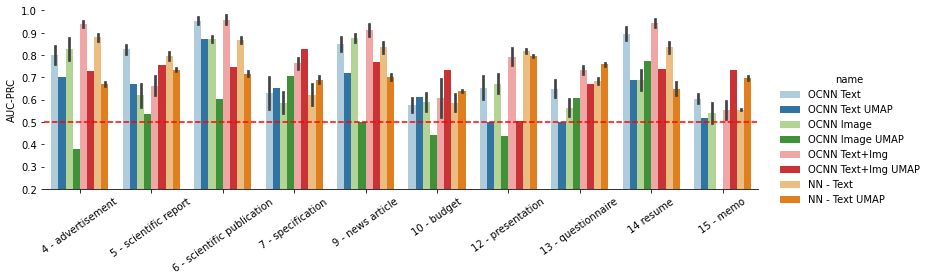

In [41]:
import matplotlib.pyplot as plt


fold = "../reports/"
balanced = 0
score = "roc_auc"

filelist = [("OCNN Text", f"{fold}final/oc_b/one_out_oc_nn_nn_bub_weakly.tsv"),
            ("OCNN Text UMAP", f"../reports/one_class/one_out_oc_0001_nn_text_umap.tsv"),
           ("OCNN Image", f"{fold}final/oc_b/one_out_oc_nn_bub_image.tsv"),
            ("OCNN Image UMAP", f"../reports/one_class/one_out_oc_0002_nn_image_umap.tsv"),
           ("OCNN Text+Img", f"{fold}one_class/one_out_oc_0001_nn__bub_imgtxt.tsv"),
           ("OCNN Text+Img UMAP", f"../reports/one_class/one_out_oc_0001_nn_combined_umap_samespace.tsv"),
           ]

df = pd.concat([load_and_add_col(x) for x in filelist])
df.cclass = df.cclass.map(lambda l: [x for x in eval(l) if x not in inliers][0])


df_temp = pd.read_csv("../reports/final/supverised/one_out_standard_sup.tsv", sep="\t")
df_temp["name"] = "NN - Text"
df_temp["cclass"] = df_temp.in_test_not_train_outlier.map(lambda x: eval(x)[0])
df_temp["balanced"] = df_temp.balance
df = pd.concat([df, df_temp])

path = "../reports/supervised/sup_one_to_many_UMAP0001.tsv"
df_temp = pd.read_csv(path, sep="\t")
df_temp["name"] = "NN - Text UMAP"
print(df_temp.outliers)
df_temp["cclass"] = df_temp.outliers.map(lambda x: eval(x)[0])
df_temp = df_temp.where(df_temp.use_umap==200).dropna(how="all")
df = pd.concat([df, df_temp])

df = df.where(df.balanced==balanced).dropna(how="all")
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="name", kind="bar", labely=score, show=False, 
                   height=4, aspect=8/3, palette="Paired")
g.set(ylim=(0.2,1.0))
g.map(plt.axhline, y=0.5, ls='--', c='red')
g.set_axis_labels("", "AUC-PRC")
plt.savefig("../thesis/pictures/UMAP_all.svg", format="svg")

df_group = df.groupby(["name"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
#print(latex_code)
df_group

In [117]:
test % 101 / 100

Float64Index([ 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
              ...
              0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,  1.0],
             dtype='float64', length=101)

## Supervised

### OE per class

\begin{tabular}{llrrrrrr}
\toprule
        &     &  f1\_macro &    f1 &  in\_rec &  out\_rec &  roc\_auc &  pr\_auc \\ \hline
n\_oe & balanced &           &       &         &          &          &         \\ \hline
\midrule
0.0     & 0.0 &     0.615 & 0.904 &   0.970 &    0.242 &    0.750 &   0.908 \\ \hline
1000.0  & 0.0 &     0.621 & 0.906 &   0.970 &    0.253 &    0.758 &   0.912 \\ \hline
40000.0 & 0.0 &     0.633 & 0.906 &   0.966 &    0.283 &    0.755 &   0.910 \\ \hline
\bottomrule
\end{tabular}



,,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
n_oe,balanced,,,,,,
0.0,0.0,0.615402,0.904211,0.970017,0.242035,0.750067,0.907941
1000.0,0.0,0.620630,0.905822,0.970146,0.253438,0.757698,0.911783
40000.0,0.0,0.633220,0.905875,0.965507,0.282949,0.755355,0.910017


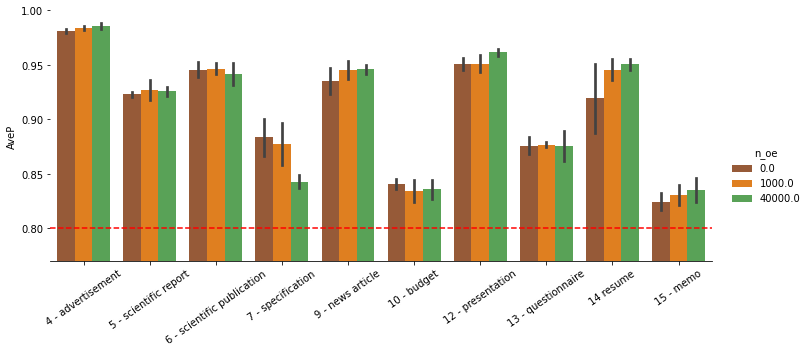

In [43]:
balanced=0
score="pr_auc"

path = "../reports/supervised/sup_one_new_out_oe0001.tsv"
df = pd.read_csv(path, sep="\t")
df["cclass"] = df.test_outliers.map(lambda x: eval(x)[0])
df_bub = df.copy(deep=True)
df = df.where(df.balanced==balanced).dropna(how="all")
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, hue="n_oe", kind="bar", labely="AU-PRC", 
                   show=False, height=5, aspect=6/3, palette="Set1_r")
g.set(ylim=(0.77,1.0))
g.map(plt.axhline, y=0.8, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/oe-per-class.svg", format="svg")

df_group = df_bub.groupby(["n_oe", "balanced"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
print(latex_code)
df_group

## One to many

\begin{tabular}{lrrrrrr}
\toprule
{} &  f1\_macro &    f1 &  in\_rec &  out\_rec &  roc\_auc &  pr\_auc \\ \hline
cclass &           &       &         &          &          &         \\ \hline
\midrule
4      &     0.514 & 0.948 &   0.996 &    0.043 &    0.597 &   0.920 \\ \hline
5      &     0.541 & 0.943 &   0.992 &    0.081 &    0.655 &   0.924 \\ \hline
6      &     0.599 & 0.948 &   1.000 &    0.143 &    0.679 &   0.926 \\ \hline
7      &     0.482 & 0.939 &   0.995 &    0.014 &    0.552 &   0.899 \\ \hline
9      &     0.536 & 0.943 &   0.994 &    0.073 &    0.630 &   0.917 \\ \hline
10     &     0.477 & 0.940 &   0.995 &    0.007 &    0.524 &   0.896 \\ \hline
12     &     0.548 & 0.947 &   0.995 &    0.084 &    0.659 &   0.927 \\ \hline
13     &     0.521 & 0.939 &   0.990 &    0.058 &    0.595 &   0.909 \\ \hline
14     &     0.490 & 0.941 &   0.999 &    0.020 &    0.549 &   0.898 \\ \hline
15     &     0.489 & 0.940 &   0.995 &    0.021 &    0.555 &   0.901 \\ \hline
\bottomr

,f1_macro,f1,in_rec,out_rec,roc_auc,pr_auc
cclass,,,,,,
4,0.514193,0.948272,0.996134,0.043137,0.596513,0.919679
5,0.541098,0.942643,0.991838,0.080702,0.655336,0.924215
6,0.598666,0.948442,0.999570,0.142857,0.679466,0.925716
7,0.482117,0.939006,0.995275,0.013605,0.552294,0.898943
9,0.536037,0.942758,0.993986,0.072917,0.630032,0.916778
10,0.476770,0.940340,0.995275,0.007018,0.524329,0.895932
12,0.548286,0.946680,0.995275,0.084249,0.658607,0.927265
13,0.520524,0.939475,0.990120,0.058419,0.595239,0.909292
14,0.490495,0.941319,0.999141,0.020408,0.548575,0.897773


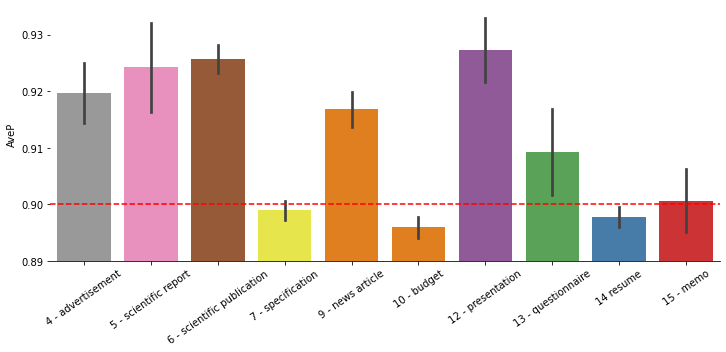

In [8]:
balanced=0
score="pr_auc"

path = "../reports/supervised/sup_one_to_many0001.tsv"
df = pd.read_csv(path, sep="\t")
df["cclass"] = df.outliers.map(lambda x: eval(x)[0])
df_bub = df.copy(deep=True)
df = df.where(df.balanced==balanced).dropna(how="all")
df = df.replace({"cclass":remap})

g = create_barplot(df, x="cclass", y=score, kind="bar", labely="AU-PRC", 
                   show=False, height=5, aspect=6/3, palette="Set1_r")
g.set(ylim=(0.89,0.935))
g.map(plt.axhline, y=0.9, ls='--', c='red')
g.set_axis_labels("", "AveP")
plt.savefig("../thesis/pictures/one-to-many.svg", format="svg")

df_group = df_bub.groupby(["cclass"]).mean()[["f1_macro", "f1", "in_rec", "out_rec", "roc_auc", "pr_auc"]]
latex_code = df_group.to_latex(float_format="%.3f")
latex_code = latex_code.replace("\\\n", "\\ \hline\n")
print(latex_code)
df_group